In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata2(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
amb_dis = np.array([[ 2.16,  2.13,  2.06,  2.21],
       [ 0.62,  0.56,  1.03,  1.46],
       [-1.57, -1.58, -0.21,  0.56],
       [-3.26, -2.5 , -1.93, -1.73]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.740361118467977).round(2)
    
def get_shifttemp(ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return ans - 6.740361118467977

In [4]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)

    weight = np.ones(diff.shape[0])
    for i in range(diff.shape[0]):
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.

        gmm = mixture.GaussianMixture(n_components = 2)
        gmm = gmm.fit(X=bicubic.reshape(-1,1))
        gmm_x = np.linspace(np.amin(bicubic),np.amax(bicubic),100)
        gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
        gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
        if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
            gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
        weight[i] = gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)]
        
    return weight

In [5]:
def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = np.floor(np.amin(bicubic)), vmax = np.ceil(np.amax(bicubic)))
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)

In [6]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            if nx == 1:
                y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
                y1 = y2-1
                ly = i*(oy-1)/(ny-1) - y1
                interpol[i,j] = garr2[y1,j-1]*(1-ly)+garr2[y2,j-1]*ly
                continue
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature(percent = 1):
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
#     arrbg = np.zeros((4,1,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        bgpath = 'train/' + temp_path[i] + '/output-empty/1.txt'
#         arrbg[i] = read_tempdata2(100,bgpath)
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
#     arrbg = thermal_interpolate(arrbg,4,1,16,1)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    print("interpolation complete")
    
    
    temp_arr = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2))

    y_train[1] = (np.ones((dis,ln**2,16))*temp_inter).transpose(2,0,1)
    y_train[2] = (np.ones((16,ln**2,dis))*np.linspace(1,4,dis)).transpose(0,2,1)
    pos_x = np.array([np.linspace(1,6,6),]*6)
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,ln**2))*pos_x.reshape(-1))
    y_train[4] = (np.ones((16,dis,ln**2))*pos_y.reshape(-1))
    y_train = y_train.reshape(5,16*dis,-1)
    print("y_train[1-4] complete")
    shifttemp = np.ones((16*dis))
    for i in range(y_train.shape[1]):
        _a = y_train[1,i,0]
        _b = y_train[2,i,0]
        shifttemp[i] = get_shifttemp(_a,_b)
    shifttemp = (np.ones((ln**2,16*dis))*shifttemp).transpose(1,0).reshape(16,-1).transpose(1,0)
    
#     mu, sigma = 36.5, 0.875 # mean and standard deviation
#     y_temp = np.clip(np.random.normal(mu, sigma,y_train.shape[1]), 36,40)
#     ol_skintemp = np.ones((y_train.shape[1]))
#     y_amb = np.copy(y_train[1])
#     for i in range(y_train.shape[1]):
#         _a = y_train[1,i]
#         _b = y_train[2,i]
#         ol_skintemp[i] = 36.5 + get_shifttemp(_a,_b)
        
#         y_temp[i] += get_shifttemp(_a,_b)
#         y_train[0,i] = (y_temp[i]-29)/7
# #         print([ol_skintemp[i],y_temp[i],y_amb[i]])
# #         y_train[0,i] = (36.5-37.5)/2.5

    y_amb = np.copy(y_train[1]) + 0.5
    y_train[1] = (y_train[1]/25) -1
    y_train = y_train.reshape(5,16,-1).transpose(2,1,0)
    y_amb = y_amb.reshape(16,-1).transpose(1,0)
#     ol_skintemp = ol_skintemp.reshape(16,-1).transpose(1,0)
#     y_temp = y_temp.reshape(16,-1).transpose(1,0)
    
    print("y_train complete")
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
            for j in range(i+1,x_train.shape[0]):
                 #add noise
                mu, sigma = 0, 0.08 # mean and standard deviation
                _n = np.clip(np.random.normal(mu, sigma, (2,5))*np.array([[0,0,1,1,1],[0,0,1,1,1]]),-0.16,0.16)
                _shift = np.array([shifttemp[i,k],shifttemp[j,k]])
                _temp = np.random.uniform(36,40,2)+_shift
                _skintemp = _shift+36.5
                y_train[i,k,0] = (_temp[0]-29)/7
                y_train[j,k,0] = (_temp[1]-29)/7
                y_train2.append(y_train[i,k]+_n[0])
                y_train2.append(y_train[j,k]+_n[1])
                y_train2.append(y_train[i,k]+_n[0])
                y_train2.append(y_train[j,k]+_n[1])
                
                _x = np.zeros((2,8,8,1))
                _xo = np.zeros((2,8,8,1))
                _r = np.random.randint(0,99,2)
                _xo[0] = x_train[i,k,_r[0]]
                _xo[1] = x_train[j,k,_r[1]]
                _x[0] = np.clip((_xo[0]-y_amb[i,k])/(_skintemp[0]-y_amb[i,k]),0,1)
                _x[1] = np.clip((_xo[1]-y_amb[j,k])/(_skintemp[1]-y_amb[j,k]),0,1)
                _x[0] = _x[0]*(_temp[0]) + (1-_x[0])*(_xo[0]+0.5) 
                _x[1] = _x[1]*(_temp[1]) + (1-_x[1])*(_xo[1]+0.5)
#                 weight = get_weight(_x,arrbg[k])
#                 wmean = np.mean(weight)
#                 _x = (_x.transpose(1,2,3,0) -(weight-wmean)).transpose(3,0,1,2)
                _xx = np.amax(_x, axis = 0)
                x_train2.append(_xx)
                x_train2.append(_xx)
                x_train2.append(_x[0])
                x_train2.append(_x[1])
#                 show_temp(x_train2[-3])
                
                
               
    del x_train, y_train
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*percent)
    return x_train2[indices[:ind]],y_train2[indices[:ind],2:], y_train2[indices[:ind],:2]

In [7]:
x_train, x_train2, y_train = load_temperature()

interpolation complete
y_train[1-4] complete
y_train complete


In [7]:
x_val, x_val2, y_val = load_temperature(0.1)

interpolation complete
y_train[1-4] complete
y_train complete


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 8, 8, 64)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

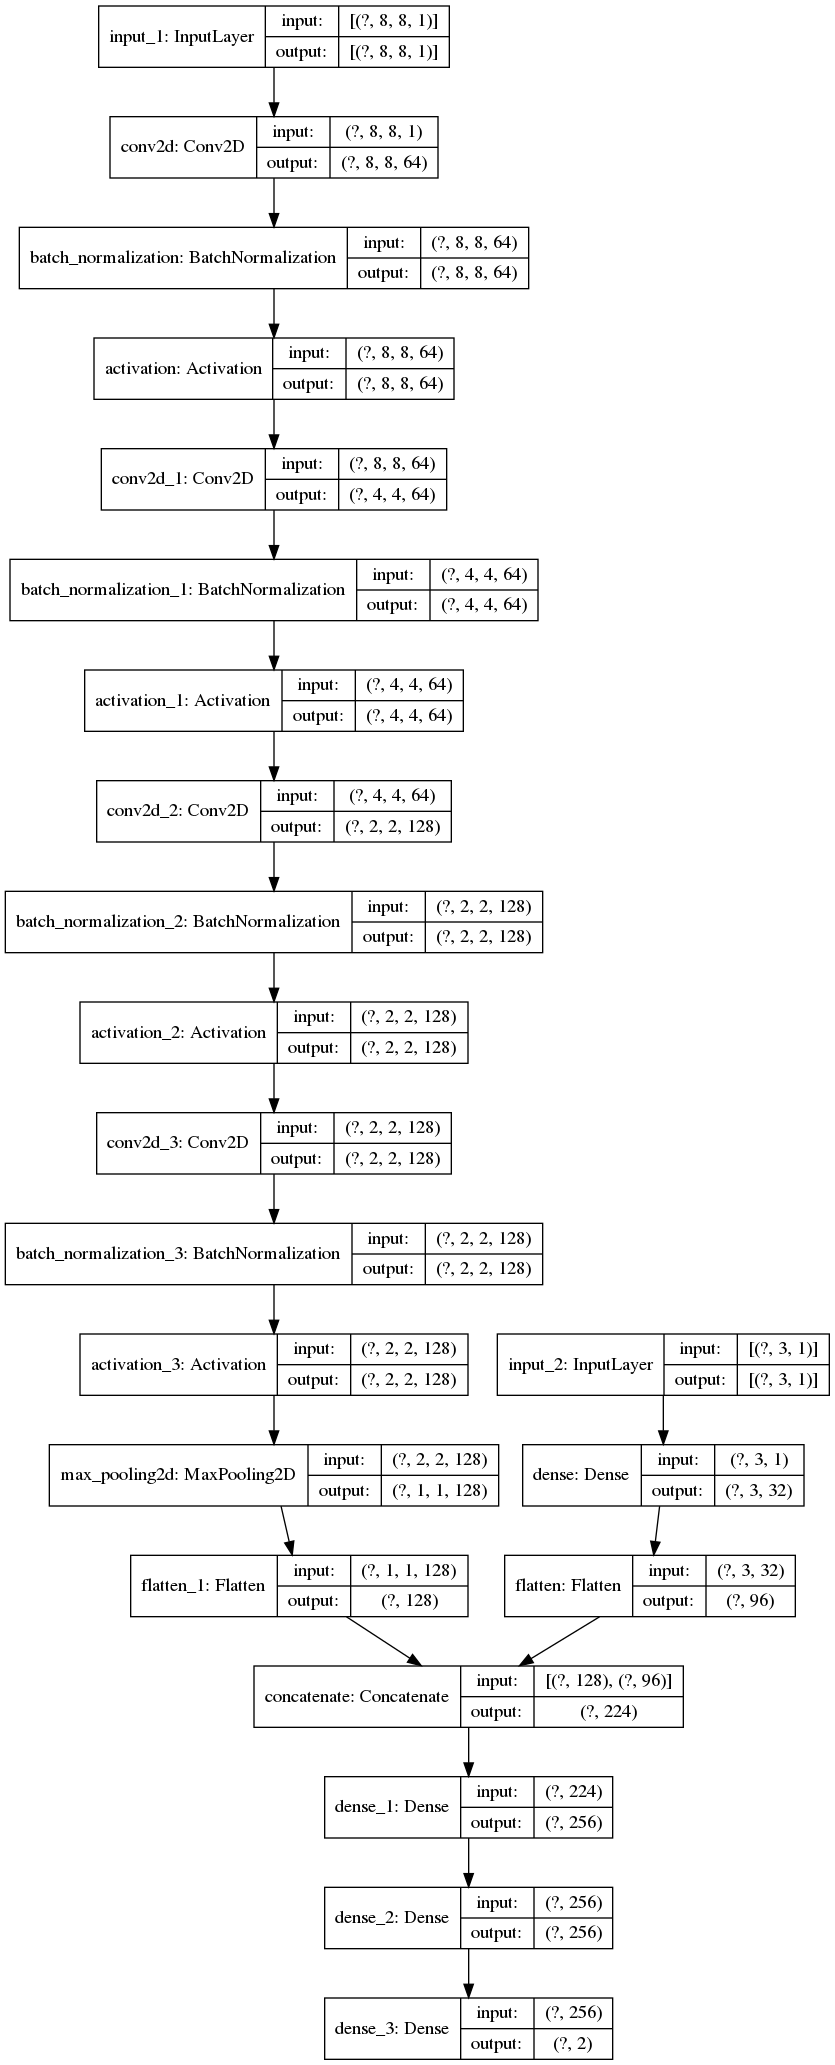

In [8]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.3
init = RandomNormal(stddev=0.02)

inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)

y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          padding = 'same')(inputs)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
# y = MaxPooling2D()(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = MaxPooling2D()(y)


y2 = Dense(32, activation='relu')(inputs2)
y2 = Flatten()(y2)


y = Flatten()(y)
y = Concatenate()([y,y2])
y = Dense(filters*4, activation='relu')(y)
y = Dense(filters*4, activation='relu')(y)
outputs = Dense(2, activation='tanh')(y)

model = Model(inputs=[inputs,inputs2], outputs=[outputs])
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [21]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(loss='mae',
              optimizer= opt,
              metrics=['accuracy'])
batch_size = 256
history = model.fit([x_train,x_train2],
          y_train,
          validation_data=([x_val,x_val2], y_val),
          epochs=100,
          batch_size=batch_size)

Epoch 1/100
41400/41400 [==============================] - 127s 3ms/step - loss: 0.0621 - accuracy: 0.8826 - val_loss: 0.0616 - val_accuracy: 0.8841
Epoch 2/100
41400/41400 [==============================] - 128s 3ms/step - loss: 0.0573 - accuracy: 0.8884 - val_loss: 0.0598 - val_accuracy: 0.8851
Epoch 3/100
41400/41400 [==============================] - 127s 3ms/step - loss: 0.0561 - accuracy: 0.8900 - val_loss: 0.0576 - val_accuracy: 0.8889
Epoch 4/100
41400/41400 [==============================] - 128s 3ms/step - loss: 0.0554 - accuracy: 0.8910 - val_loss: 0.0570 - val_accuracy: 0.8898
Epoch 5/100
41400/41400 [==============================] - 128s 3ms/step - loss: 0.0548 - accuracy: 0.8917 - val_loss: 0.0559 - val_accuracy: 0.8905
Epoch 6/100
41400/41400 [==============================] - 127s 3ms/step - loss: 0.0544 - accuracy: 0.8923 - val_loss: 0.0622 - val_accuracy: 0.8854
Epoch 7/100
41400/41400 [==============================] - 128s 3ms/step - loss: 0.0541 - accuracy: 0.8927

In [22]:
res = np.array(model.predict([x_val, x_val2])*np.array([7,25])+np.array([29,25]))

In [23]:
l = []
for i in range(100):
    l.append(abs(get_bodytemp(res[i,0],res[i,1],x_val2[i,0]) - get_bodytemp(y_val[i,0]*7+29,y_val[i,1]*25+25,x_val2[i,0])))
np.median(np.array(l))

0.4199999999999946

[37.84, 38.58, -0.7399999999999949]


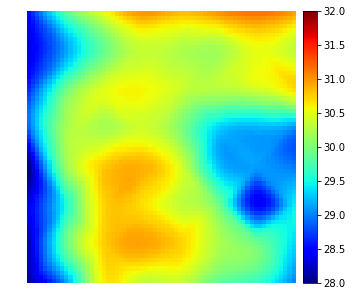

[37.77, 38.19, -0.4199999999999946]


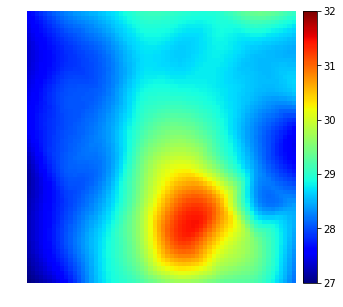

[38.01, 39.45, -1.4400000000000048]


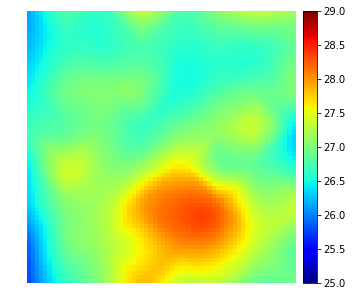

[36.98, 37.0, -0.020000000000003126]


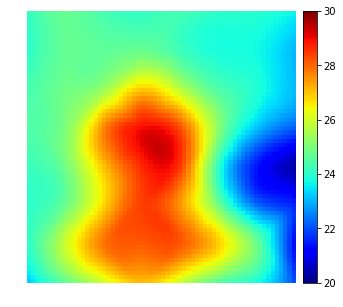

[37.13, 37.14, -0.00999999999999801]


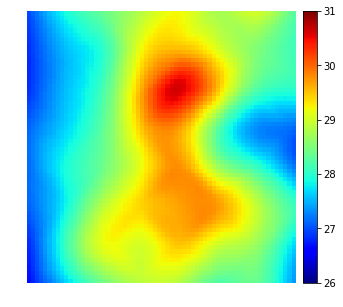

[39.19, 38.92, 0.269999999999996]


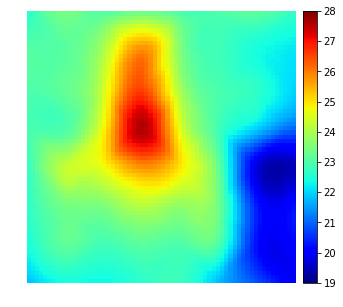

[37.93, 36.82, 1.1099999999999994]


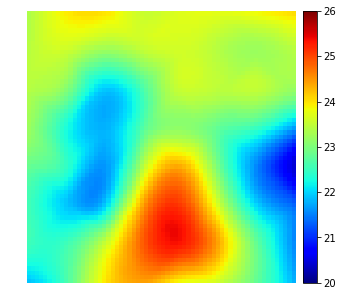

[38.01, 38.74, -0.730000000000004]


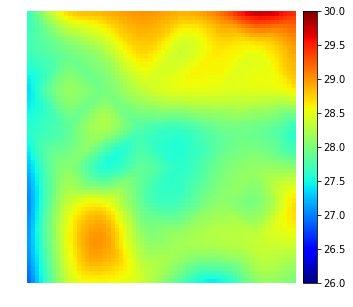

[38.08, 37.83, 0.25]


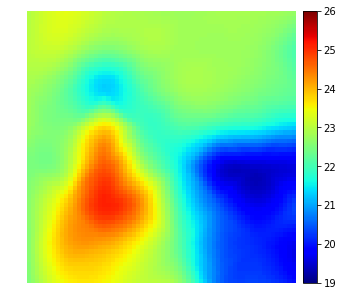

[37.4, 37.59, -0.19000000000000483]


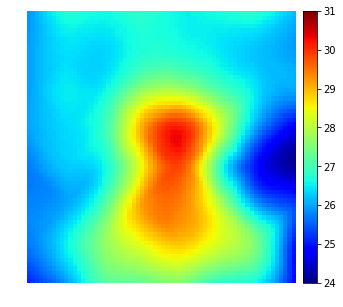

[37.98, 37.48, 0.5]


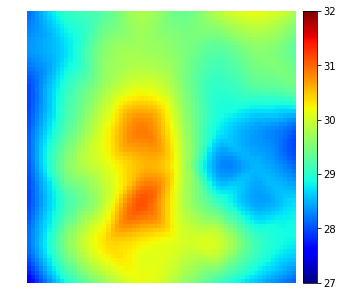

[37.31, 37.36, -0.04999999999999716]


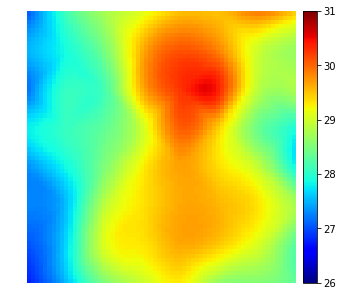

[38.35, 36.43, 1.9200000000000017]


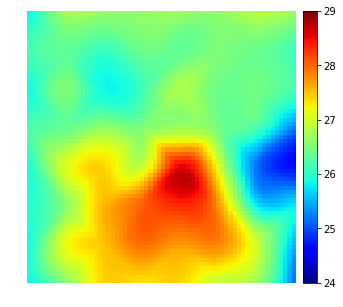

[39.25, 38.96, 0.28999999999999915]


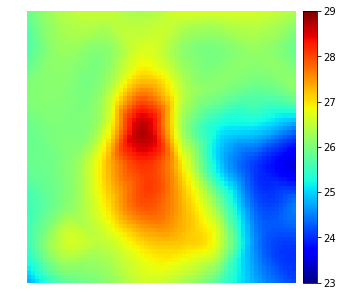

[38.42, 38.43, -0.00999999999999801]


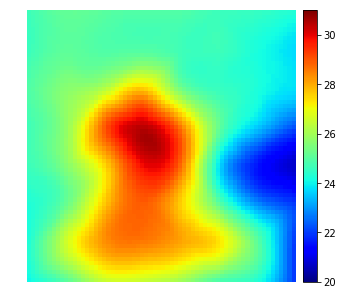

[38.0, 39.37, -1.3699999999999974]


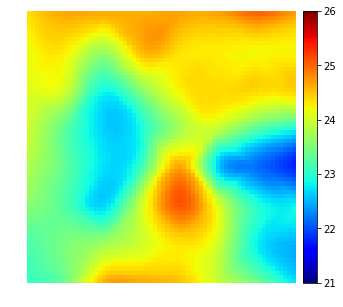

[37.99, 37.37, 0.6200000000000045]


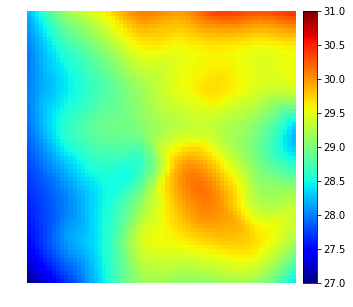

[37.9, 38.52, -0.6200000000000045]


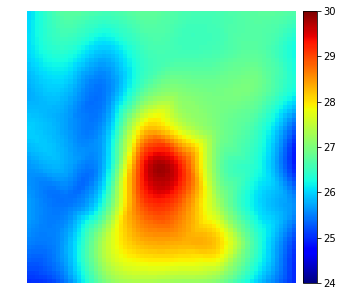

[37.89, 38.12, -0.22999999999999687]


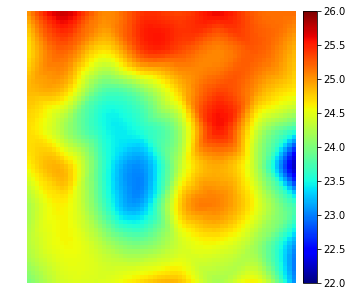

[37.87, 37.95, -0.0800000000000054]


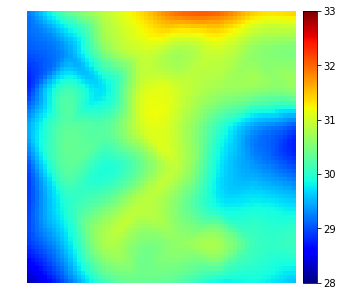

[38.11, 37.83, 0.28000000000000114]


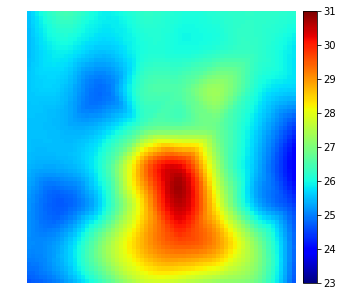

[38.04, 36.77, 1.269999999999996]


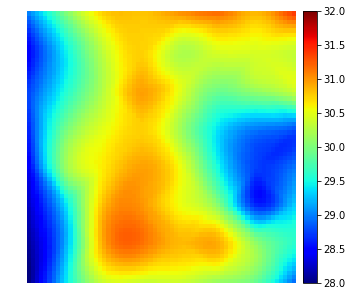

[39.01, 39.56, -0.5500000000000043]


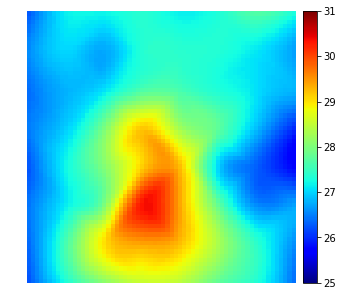

[37.94, 37.95, -0.010000000000005116]


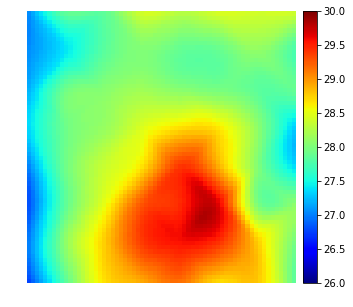

[38.0, 39.1, -1.1000000000000014]


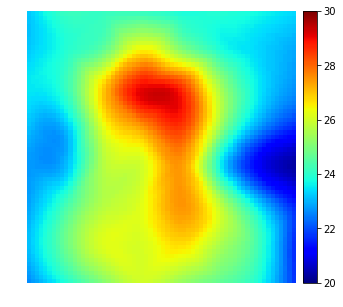

[38.33, 38.19, 0.14000000000000057]


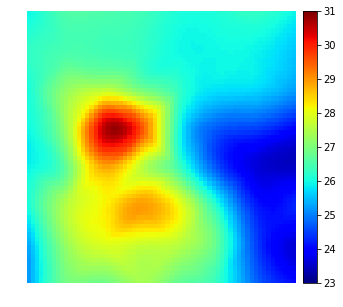

[37.73, 37.78, -0.05000000000000426]


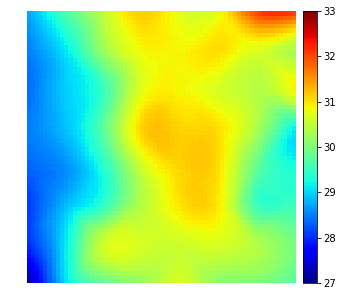

[38.03, 36.39, 1.6400000000000006]


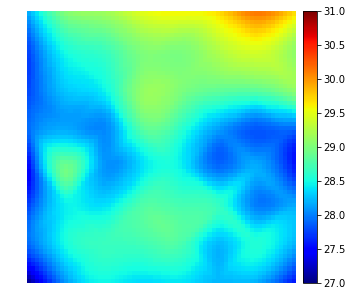

[38.99, 38.98, 0.010000000000005116]


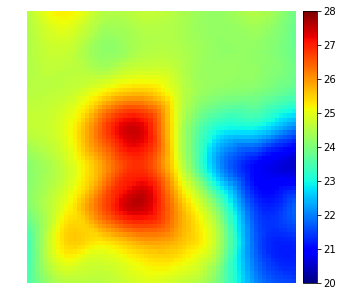

[39.73, 39.9, -0.1700000000000017]


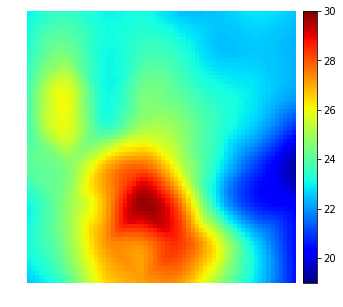

[36.29, 36.26, 0.030000000000001137]


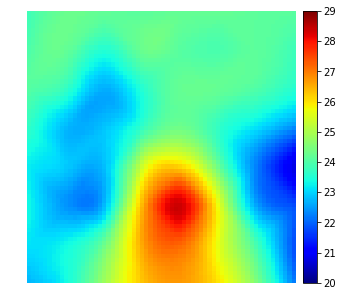

[38.05, 38.68, -0.6300000000000026]


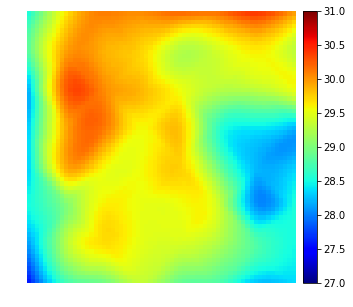

[38.07, 37.5, 0.5700000000000003]


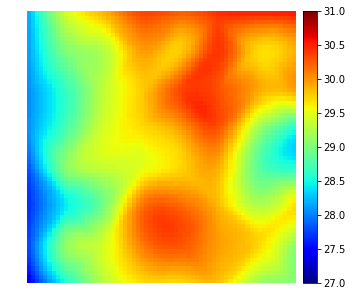

[37.23, 37.25, -0.020000000000003126]


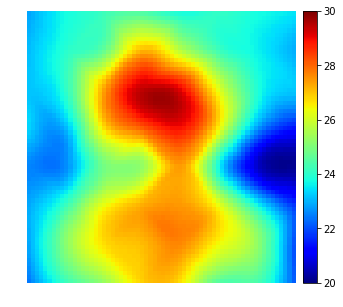

[38.48, 38.87, -0.39000000000000057]


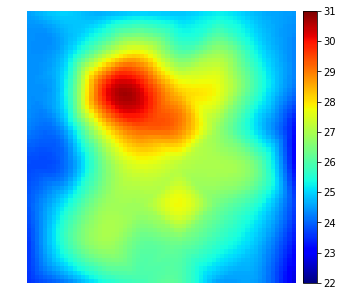

[38.04, 37.45, 0.5899999999999963]


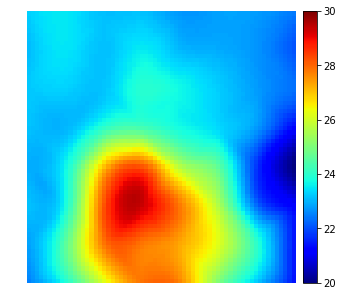

[37.99, 36.53, 1.4600000000000009]


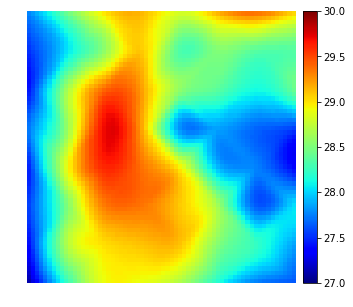

[37.06, 37.07, -0.00999999999999801]


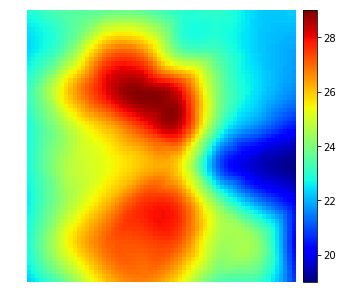

[38.03, 38.69, -0.6599999999999966]


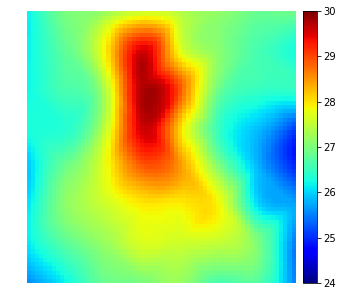

[38.0, 40.0, -2.0]


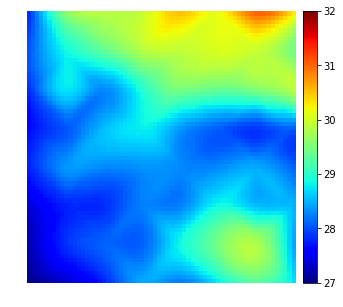

[38.04, 39.21, -1.1700000000000017]


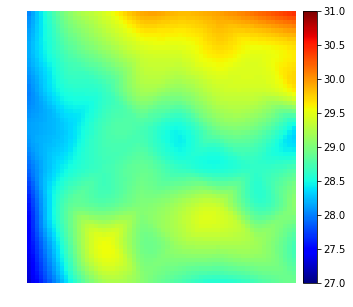

[38.05, 37.39, 0.6599999999999966]


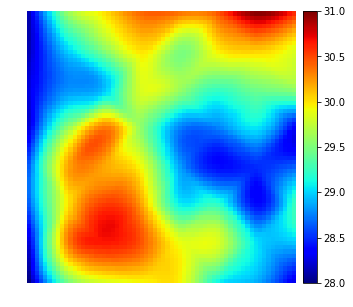

[38.0, 37.15, 0.8500000000000014]


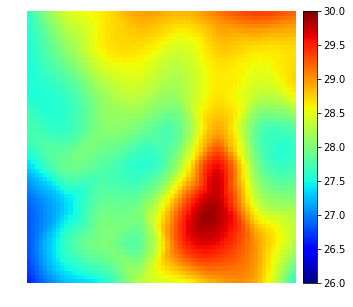

[36.77, 36.46, 0.3100000000000023]


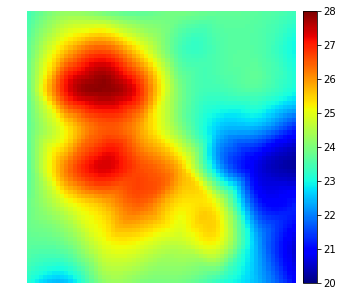

[38.01, 37.86, 0.14999999999999858]


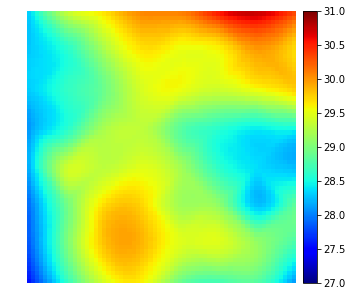

[38.03, 38.32, -0.28999999999999915]


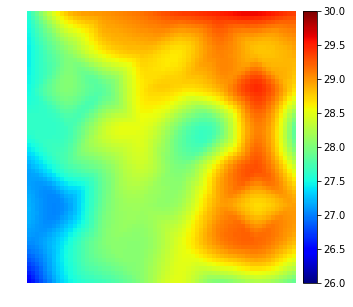

[38.05, 37.3, 0.75]


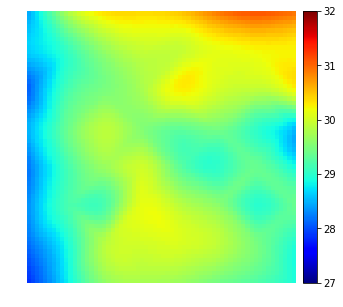

[37.99, 38.02, -0.030000000000001137]


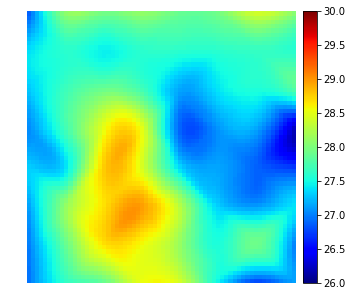

[38.1, 38.44, -0.3399999999999963]


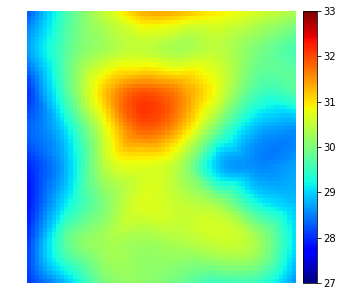

[38.02, 37.84, 0.17999999999999972]


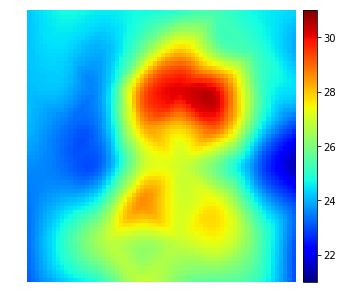

[39.14, 39.09, 0.04999999999999716]


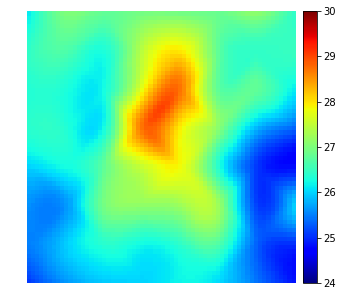

[38.11, 38.18, -0.07000000000000028]


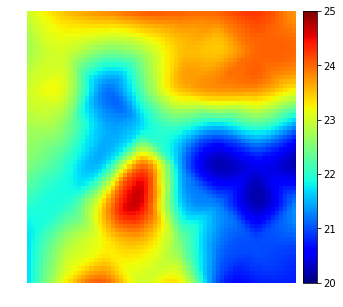

[38.02, 39.07, -1.0499999999999972]


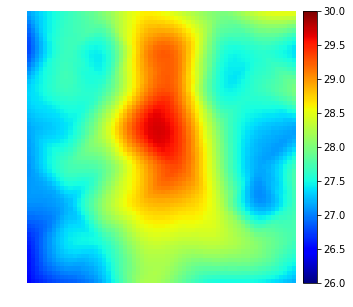

[37.74, 38.12, -0.37999999999999545]


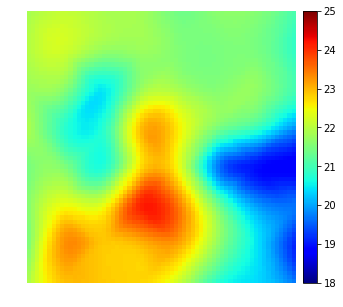

[37.99, 36.16, 1.8300000000000054]


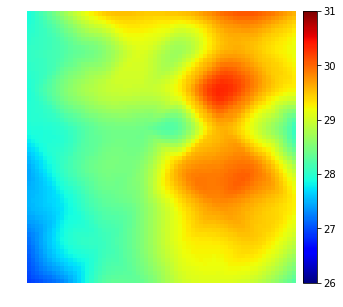

[37.96, 38.87, -0.9099999999999966]


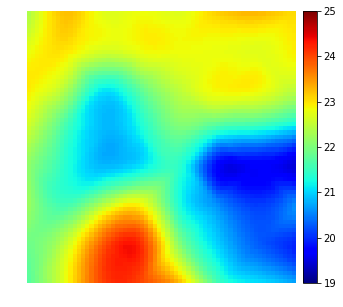

[37.5, 39.9, -2.3999999999999986]


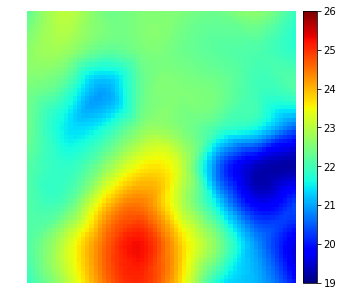

[37.73, 37.58, 0.14999999999999858]


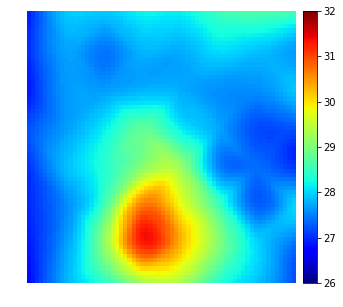

[38.02, 38.73, -0.7099999999999937]


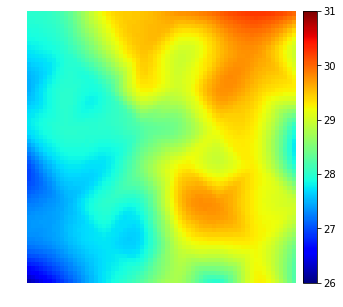

[36.34, 36.29, 0.05000000000000426]


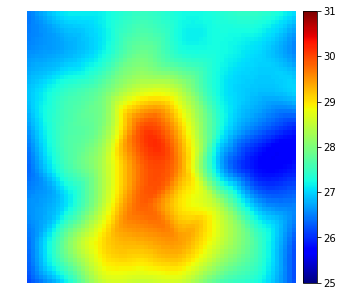

[39.79, 40.12, -0.3299999999999983]


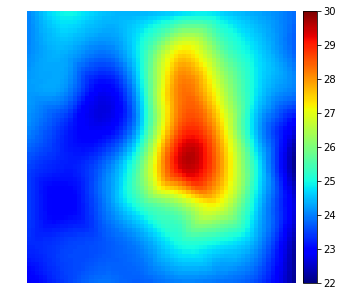

[38.49, 38.31, 0.17999999999999972]


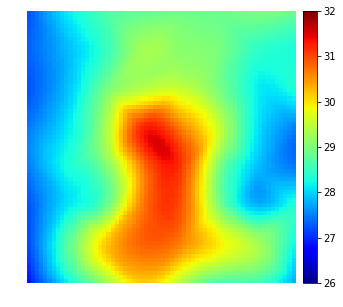

[37.99, 36.48, 1.5100000000000051]


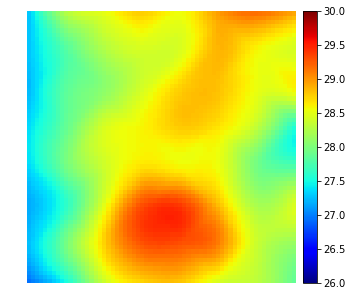

[37.85, 36.27, 1.5799999999999983]


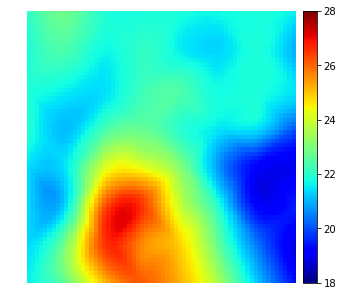

[38.02, 38.97, -0.9499999999999957]


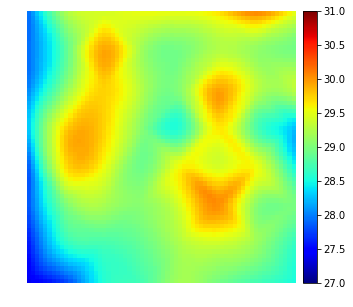

[37.19, 37.31, -0.12000000000000455]


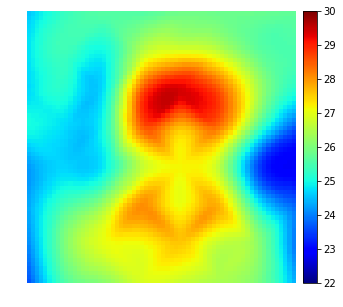

[37.94, 38.1, -0.1600000000000037]


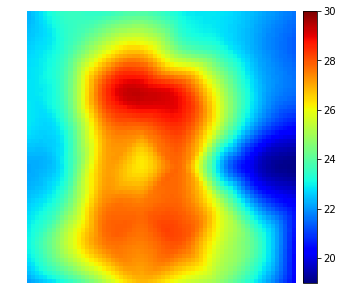

[39.53, 39.92, -0.39000000000000057]


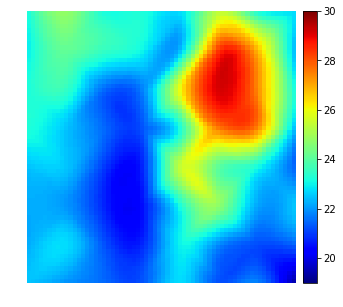

[39.08, 38.9, 0.17999999999999972]


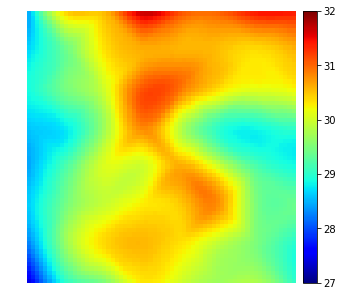

[37.54, 37.56, -0.020000000000003126]


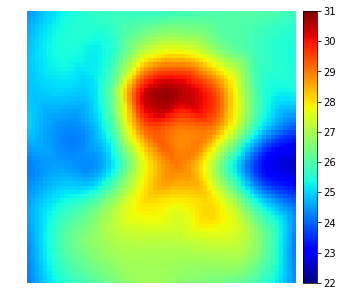

[38.12, 36.18, 1.9399999999999977]


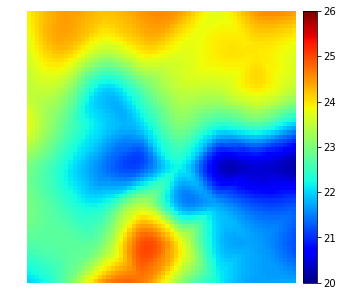

[36.13, 36.21, -0.0799999999999983]


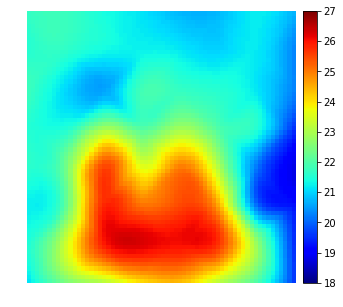

[37.23, 37.0, 0.22999999999999687]


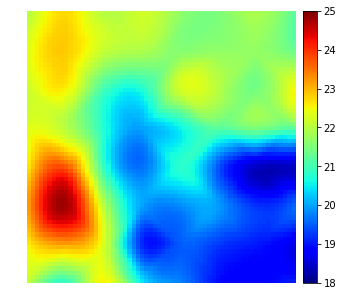

[37.48, 36.93, 0.5499999999999972]


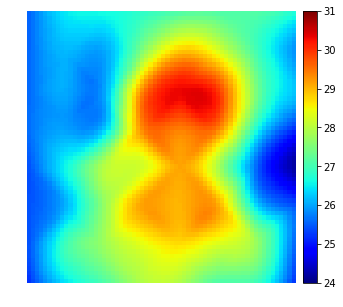

[37.92, 36.2, 1.7199999999999989]


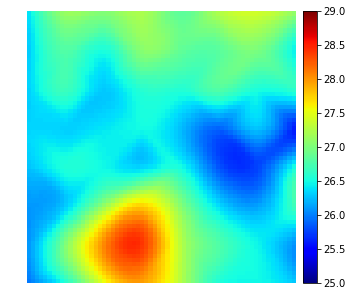

[38.13, 39.59, -1.4600000000000009]


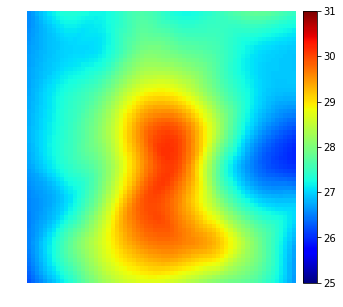

[38.5, 40.01, -1.509999999999998]


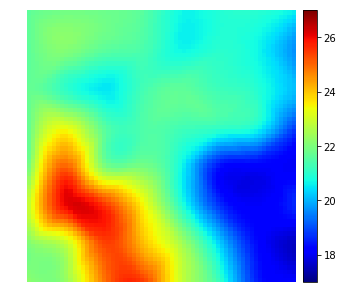

[38.06, 39.93, -1.8699999999999974]


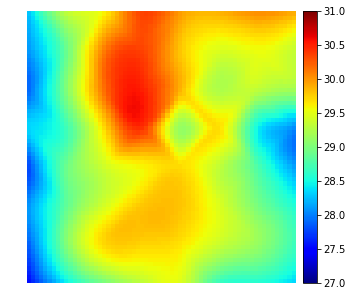

[37.39, 39.71, -2.3200000000000003]


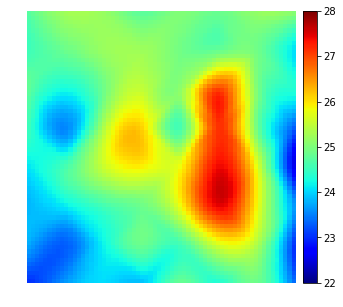

[36.06, 36.01, 0.05000000000000426]


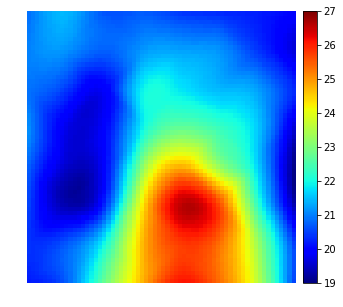

[37.87, 37.2, 0.6699999999999946]


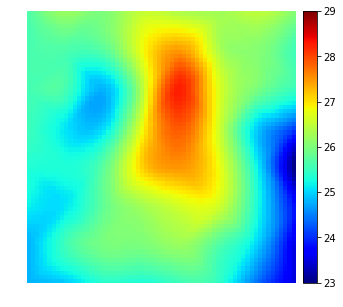

[37.99, 38.01, -0.01999999999999602]


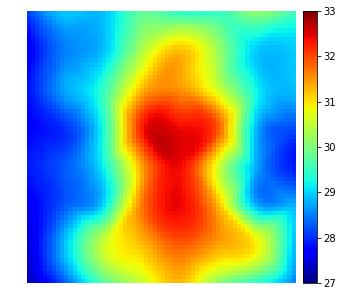

[37.96, 37.92, 0.03999999999999915]


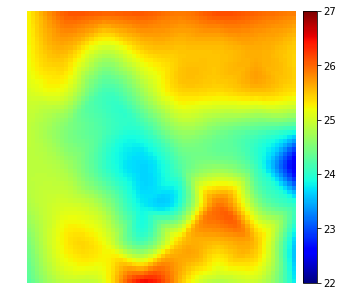

[38.02, 37.54, 0.480000000000004]


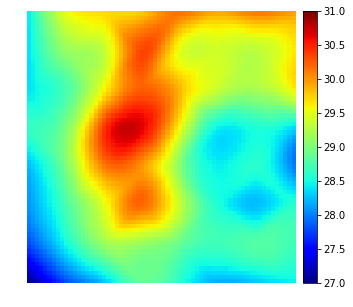

[37.76, 37.17, 0.5899999999999963]


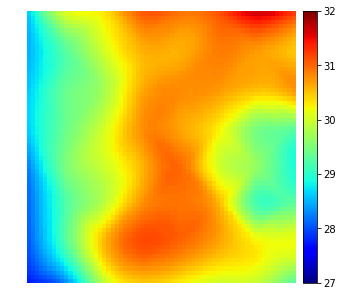

[38.1, 38.73, -0.6299999999999955]


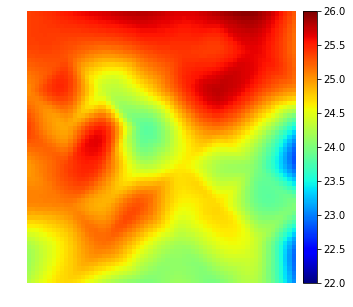

[37.96, 37.74, 0.21999999999999886]


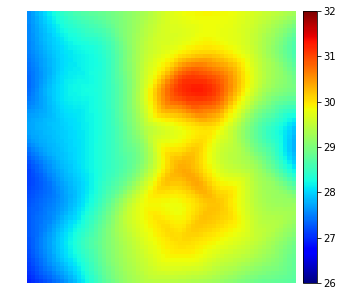

[38.49, 38.91, -0.4199999999999946]


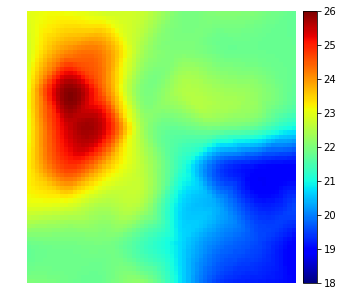

[38.05, 39.9, -1.8500000000000014]


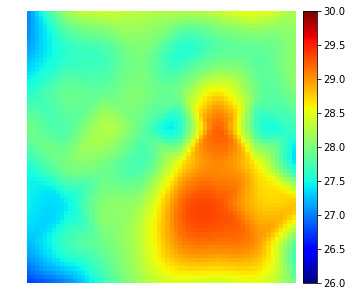

[37.56, 37.58, -0.01999999999999602]


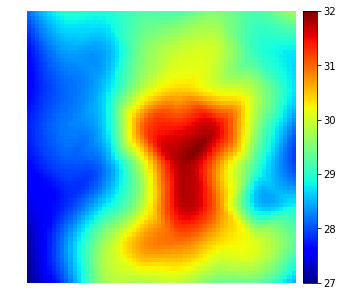

[37.98, 36.06, 1.9199999999999946]


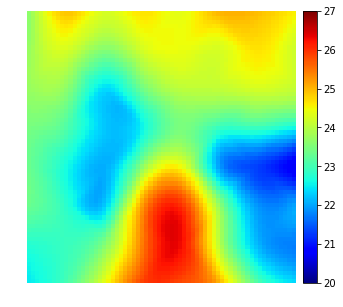

[37.48, 38.49, -1.0100000000000051]


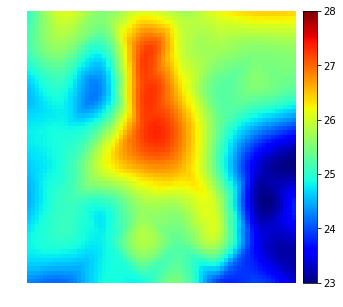

[37.86, 36.79, 1.0700000000000003]


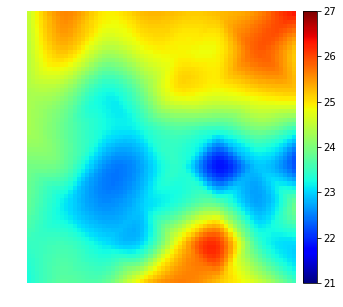

[37.9, 39.94, -2.039999999999999]


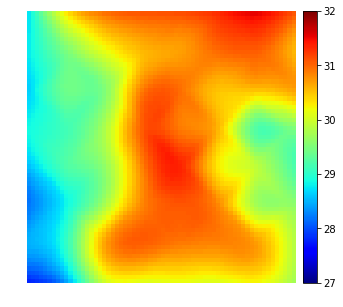

[38.94, 38.62, 0.3200000000000003]


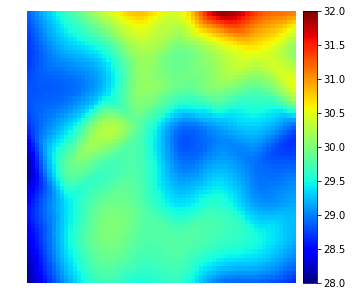

[38.76, 38.2, 0.5599999999999952]


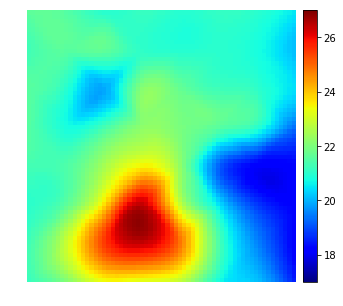

[38.45, 38.58, -0.12999999999999545]


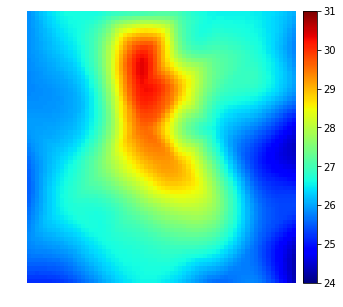

[37.86, 37.53, 0.3299999999999983]


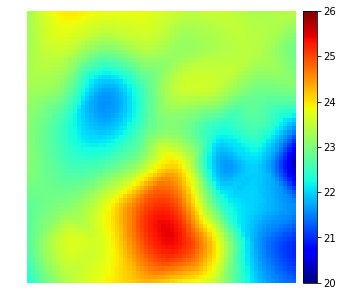

[37.83, 37.6, 0.22999999999999687]


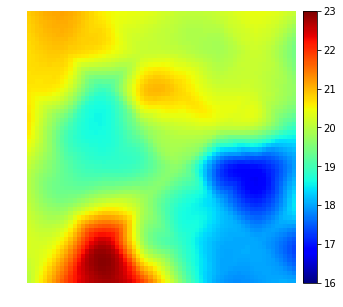

[38.0, 36.25, 1.75]


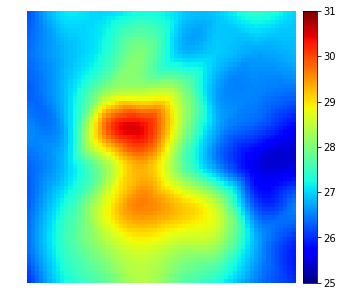

In [27]:
num = 0
for i in range(100):
    a = get_bodytemp(res[i,0],res[i,1],x_val2[i,0])
    b = get_bodytemp(y_val[i,0]*7+29,y_val[i,1]*25+25,x_val2[i,0])
#     if abs(a - b) >= 1:
    print([a,b,a - b])
    show_temp(x_val[i])
#         num += 1
# print(num/100)

In [28]:
model.save('prefinal_model.h5')

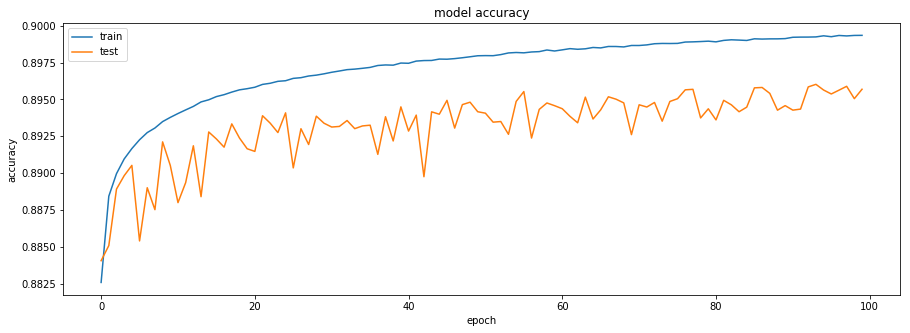

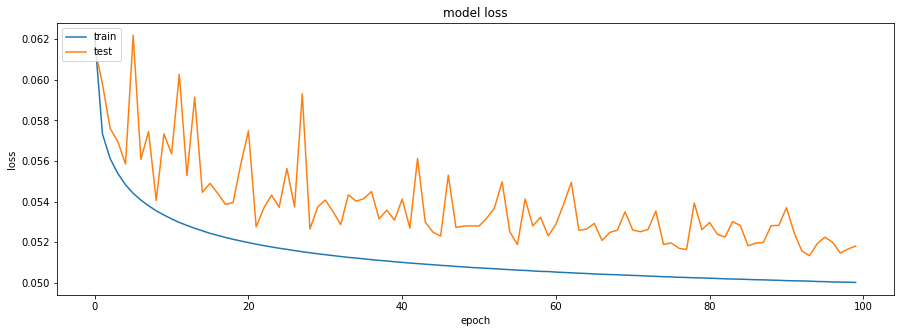

In [29]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [9]:
model.load_weights('prefinal_model.h5')

In [10]:
res = np.array(model.predict([x_val, x_val2])*np.array([7,25])+np.array([29,25]))
yy =y_val*np.array([7,25])+np.array([29,25])

In [ ]:
l = []
cnt = 0
for i in range(res.shape[0]):
    _a = abs(get_bodytemp(res[i,0],res[i,1],res[i,2])-get_bodytemp(yy[i,0],yy[i,1],yy[i,2]))
    if _a > 1:
       cnt+=1 
    l.append(_a)
print(np.median(np.array(l)))
print (cnt/res.shape[0])

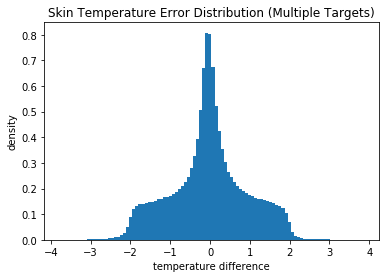

[-0.024617729876893632, -0.028061525188270764, 0.8908776263641637, 0.9438631396363372]
[1.8877262792726743, -1.912344009149568, 1.8631085493957806]


In [12]:
l1 = res[:,0]-yy[:,0] 
plt.hist(l1, bins=100, density = True )
plt.title('Skin Temperature Error Distribution (Multiple Targets)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l1),np.median(l1),np.var(l1),np.std(l1)])
print([np.std(l1)*2, np.mean(l1)-np.std(l1)*2, np.mean(l1)+np.std(l1)*2])

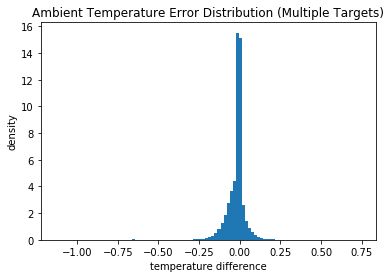

[-0.020021836690877485, -0.009026297817124274, 0.0035631014331851036, 0.059691719971744016]
[0.11938343994348803, -0.13940527663436553, 0.09936160325261055]


In [13]:
l1 = res[:,1]-yy[:,1] 
plt.hist(l1, bins=100, density = True )
plt.title('Ambient Temperature Error Distribution (Multiple Targets)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l1),np.median(l1),np.var(l1),np.std(l1)])
print([np.std(l1)*2, np.mean(l1)-np.std(l1)*2, np.mean(l1)+np.std(l1)*2])

In [14]:
l = []
for i in range(res.shape[0]):
    _a = get_bodytemp(res[i,0],res[i,1],x_val2[i,0])-get_bodytemp(yy[i,0],yy[i,1],x_val2[i,0])
    l.append(_a)

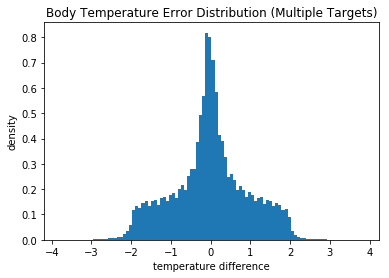

[-0.012703124999999985, -0.020000000000003126, 0.8886494790451862, 0.9426820667887907]
[1.8853641335775815, -1.8980672585775815, 1.8726610085775814]


In [16]:
plt.hist(l, bins=100, density = True )
plt.title('Body Temperature Error Distribution (Multiple Targets)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l),np.median(l),np.var(l),np.std(l)])
print([np.std(l)*2, np.mean(l)-np.std(l)*2, np.mean(l)+np.std(l)*2])

In [51]:
(np.abs(l) < 1.8).sum()/len(l)

0.9348552611714975

In [54]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(metrics=['accuracy','binary_accuracy'])
score = model.evaluate([x_val, x_val2], y_val, batch_size=256)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

4140/4140 [==============================] - 5s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8966 - binary_accuracy: 0.0000e+00

Test accuracy: 89.7%


In [47]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(loss='mae',
              optimizer= opt,
              metrics=['accuracy', tf.keras.metrics.mae])
score = model.evaluate([x_val, x_val2], y_val, batch_size=256)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

4140/4140 [==============================] - 5s 1ms/step - loss: 0.0517 - accuracy: 0.8966 - mean_absolute_error: 0.0517

Test accuracy: 89.7%


In [59]:
m = tf.keras.metrics.Accuracy()
m.update_state([[1], [0.5], [0.8], [0.9]], [[1], [1], [1], [1]])
m.result().numpy()

0.25

AttributeError: 'Functional' object has no attribute 'result'

In [61]:
(np.abs(l) < 0.1).sum()/len(l)

0.15132944595410627

In [62]:
np.abs(l).sum()/len(l)

0.7129875547252417

In [65]:
(np.array(l)**2).sum()/len(l)

0.8860769683159718